Problem statement

Flying has been the go-to mode of travel for years now; it is time-saving, affordable, and extremely convenient. According to the FAA, 2,781,971 passengers fly every day in the US, as in June 2019. Passengers reckon that flying is very safe, considering strict inspections are conducted and security measures are taken to avoid and/or mitigate any mishappenings. However, there remain a few chances of unfortunate incidents.

Imagine you have been hired by a leading airline. You are required to build Machine Learning models to anticipate and classify the severity of any airplane accident based on past incidents. With this, all airlines, even the entire aviation industry, can predict the severity of airplane accidents caused due to various factors and, correspondingly, have a plan of action to minimize the risk associated with them.

We challenge you to build a model that predicts how severe an airplane accident could be. Score parameter will be f1

In [3]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#importing lib

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from imblearn.over_sampling import SMOTE



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
#importing train_dataset

train_dataset = pd.read_csv('/content/gdrive/My Drive/KaggleProjects/Severity Challenge/train.csv')

EDA (Explonatory Data Analysis)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int64
Total_Safety_Complaints    10000 non-null int64
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int64
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int64
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 937.6+ KB


In [7]:
train_dataset.head()

Severity  ...  Accident_ID
0                Minor_Damage_And_Injuries  ...         7570
1                Minor_Damage_And_Injuries  ...        12128
2        Significant_Damage_And_Fatalities  ...         2181
3  Significant_Damage_And_Serious_Injuries  ...         5946
4        Significant_Damage_And_Fatalities  ...         9054

[5 rows x 12 columns]

1) Severity is the target variable , Accident_type_code and Voilations is categorical variable

In [8]:
train_dataset.describe().T

count          mean  ...           75%           max
Safety_Score             10000.0     41.876406  ...     52.511416    100.000000
Days_Since_Inspection    10000.0     12.931100  ...     15.000000     23.000000
Total_Safety_Complaints  10000.0      6.564300  ...      9.000000     54.000000
Control_Metric           10000.0     65.145324  ...     73.336372    100.000000
Turbulence_In_gforces    10000.0      0.381495  ...      0.451346      0.882648
Cabin_Temperature        10000.0     79.969331  ...     81.560000     97.510000
Accident_Type_Code       10000.0      3.814900  ...      5.000000      7.000000
Max_Elevation            10000.0  32001.803282  ...  38380.641513  64297.651218
Violations               10000.0      2.012200  ...      3.000000      5.000000
Adverse_Weather_Metric   10000.0      0.255635  ...      0.354059      2.365378
Accident_ID              10000.0   6266.554200  ...   9391.500000  12500.000000

[11 rows x 8 columns]

1) Safety score is skewed,very few of airplane has safety score more than 50
2) higher complaints rates ,higher control metric high turbu. in force and high cabin temp has high safety score and compare to few complains but in some cases
3) very few accident type are belong to code 5 and above most of them are below 5
4) Less max elevation has less safity score 
5) Most of Violation are below 3
6) Max Elevation is skewed

In [0]:
catego_col = ['Accident_Type_Code','Violations','Severity']

In [10]:
sb.pairplot(train_dataset,hue='Severity')
plt.legend(loc='best')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

-Here you can see that safety score is -vely correlated with days_since_inspection i.e. lesser the days_since_inspection higher the safety score
-Most of the class are belong to highly_fatal and Damaging , It means that train_dataset is highly imbalance we need to balanced it by using smote technique

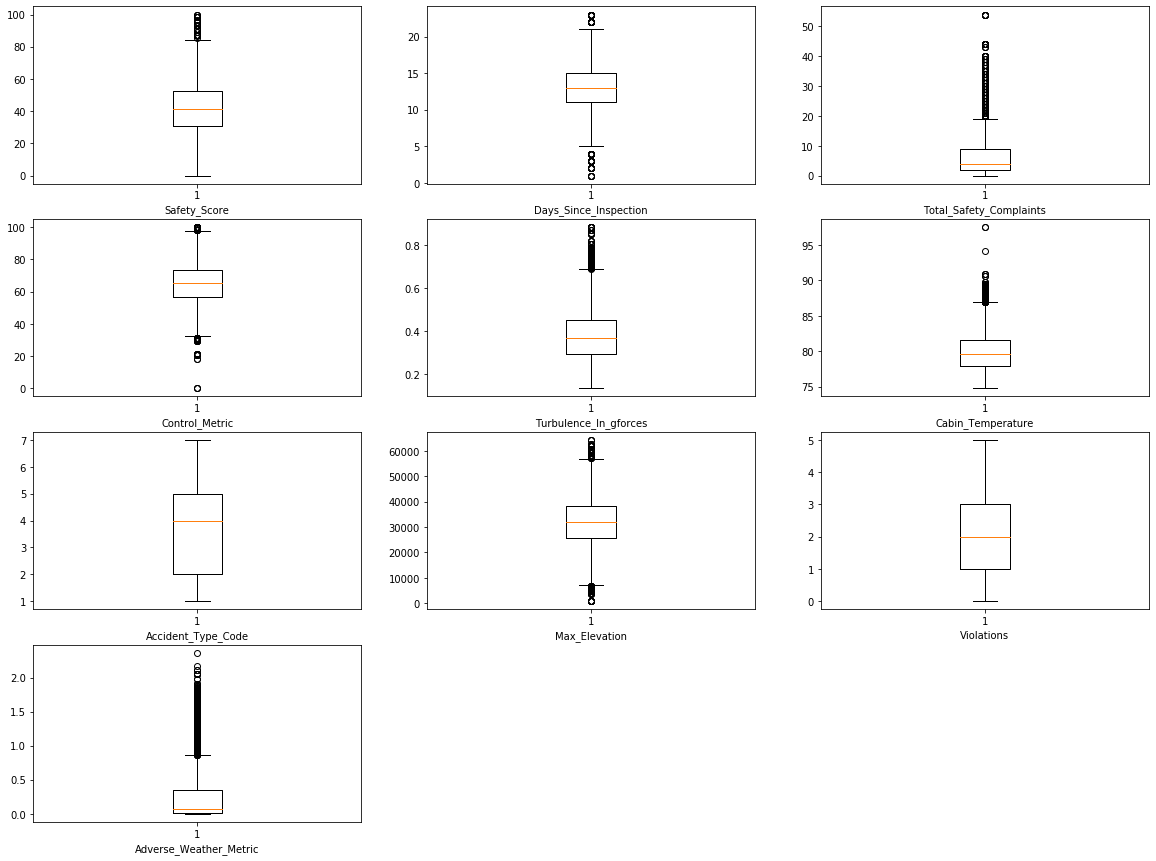

In [11]:
#lets check outlier
plt.figure(figsize=(20,15))
j = 0
for i in train_dataset.drop(columns=['Severity','Accident_ID']).columns:
  j+=1
  plt.subplot(4,3,j)
  plt.boxplot(train_dataset[i])
  plt.xlabel(i)

plt.show()

Lets analysis data in more details


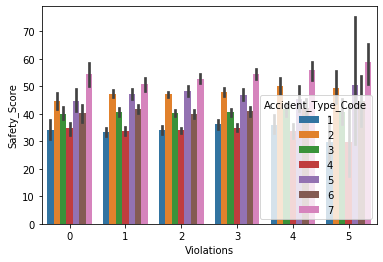

In [12]:
sb.barplot(y=train_dataset.Safety_Score,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

safety score is high for voilation 5 with accident type code 4


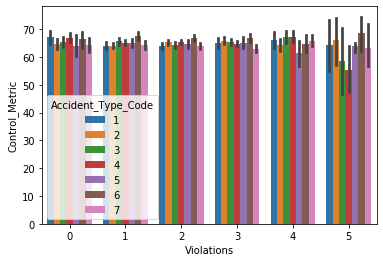

In [13]:
sb.barplot(y=train_dataset.Control_Metric,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

control metric has uniformly distributed over each voilation and accient_type_code except for voliation type 5

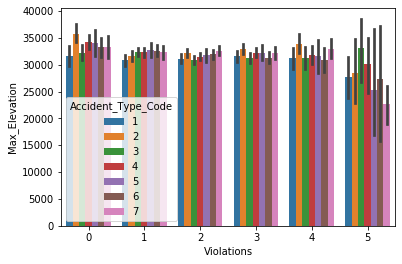

In [14]:
sb.barplot(y=train_dataset.Max_Elevation,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

max elevation has uniformly distributed over each voilation and accient_type_code except for voliation type 5

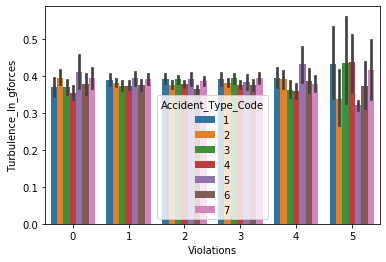

In [15]:
sb.barplot(y=train_dataset.Turbulence_In_gforces,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)


Turbulence in gforces has uniformly distributed over each voilation and accient_type_code except for voliation type 5

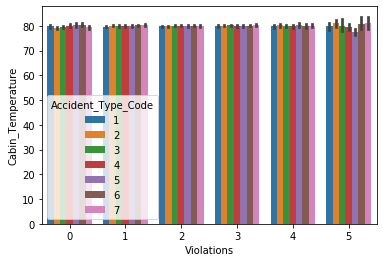

In [16]:
 sb.barplot(y=train_dataset.Cabin_Temperature,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

No outlier present in this case data is uniformly distributed

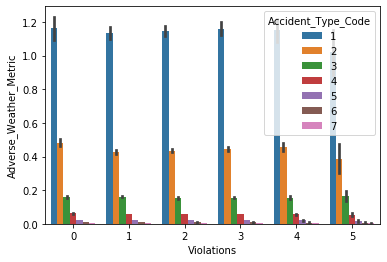

In [17]:
 sb.barplot(y=train_dataset.Adverse_Weather_Metric,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

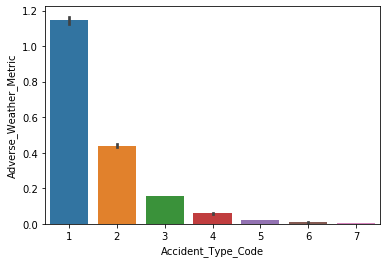

In [18]:
sb.barplot(y=train_dataset.Adverse_Weather_Metric,x=train_dataset.Accident_Type_Code)

-Here you can see that data is skewed you can handle this data at accident type level in order to avoid outlier

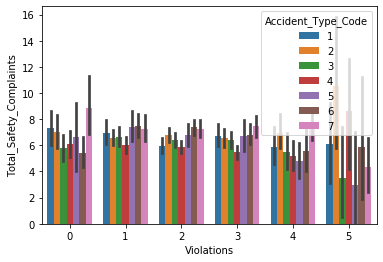

In [19]:
sb.barplot(y=train_dataset.Total_Safety_Complaints,x=train_dataset.Violations,hue=train_dataset.Accident_Type_Code)

almost data is uniformly distributed but these are no of complaints either you can handle outlier or not its totally depends on you and busniess req

Note : Here I am not handling any outlier if you want to handle I already provided analysis and tech to be used

In [0]:

def preprocessing(dummy_dataset):
    
    #droping the accident_id column
    dataset = dummy_dataset.drop(columns=['Accident_ID'])

    #converting columns into categorical columns
    for i in dataset.columns:
        if i in catego_col:
            dataset[i] = pd.Categorical(dataset[i])
    
    #mapping target into interger values        
    severity_map = {'Highly_Fatal_And_Damaging' : 0 ,'Significant_Damage_And_Serious_Injuries' : 1 ,'Minor_Damage_And_Injuries' : 2,'Significant_Damage_And_Fatalities':3}
    
    if 'Severity' in dataset.columns:
        dataset.Severity.replace(to_replace=severity_map,inplace=True)
    
    #defining independent and dependent variable
    x = pd.get_dummies(dataset,columns=['Violations','Accident_Type_Code']) #one hot encoding of categorical variables
    
    if 'Severity' in dataset.columns:
        y = dataset['Severity']
        x = x.drop(columns=['Severity','Violations_5','Accident_Type_Code_7'])
    else:
        y = None
        x = x.drop(columns=['Violations_5','Accident_Type_Code_7'])
        
    print("file preprocessing has been done ")
    return x , y

In [0]:
def outputfile(testdata):
    
    #creating accident_id and severity column
    submission_file = pd.DataFrame(columns=['Accident_ID','Severity'],index=None)
    
    #assinging accidentid and severity
    submission_file['Accident_ID']= testdata['Accident_ID']
    submission_file['Severity'] = y_predicted
    severity_map1 = {0:'Highly_Fatal_And_Damaging',1:'Significant_Damage_And_Serious_Injuries',2:'Minor_Damage_And_Injuries',3:'Significant_Damage_And_Fatalities'}
    submission_file['Severity'].replace(to_replace=severity_map1,inplace=True)
    
    #creating file
    submission_file.to_csv('/content/gdrive/My Drive/KaggleProjects/Severity Challenge/final_submission.csv',index=False)
    print("File has been successfully created")

In [0]:

#defining tunning parameter
params = {
    'learning_rate' : [0.1,0.001,0.01],
    'max_depth': [3,5,7,11],
    'min_child_weight' : [1,2,3,5],
    'lamdba':[0.5,1,2,0.2,0.3],
    'gamma':[0.1,0.2,0.3],
    'scale_pos_weight' : [1,3,2,0.5],
    'objective':'multi:softmax',
    'num_class': [4],
    'subsample':[0.5,1],
    'n_estimators':[1000],
    'early_stopping_rounds':[2],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9 ],
    'num_boost_round' :[999]
}


#defining model
classifier = xgb.XGBClassifier()

#cross calidation fold for data validation 
stf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)

#parameter tunning algo
random = RandomizedSearchCV(estimator=classifier,param_distributions=params,n_iter=10,scoring='f1_weighted',cv=stf,verbose=1,n_jobs=-1)

In [23]:
#calling the preprocessing fucntions
x , y = preprocessing(train_dataset)

#fitting the model
random.fit(x,y)

#taking best estimators with it's parameter
algo = random.best_estimator_


file preprocessing has been done 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 27.3min finished


AttributeError: ignored

In [24]:
from joblib import dump,load
dump(algo,'/content/gdrive/My Drive/KaggleProjects/Severity Challenge/airplaneseverityalssification.joblib')

['/content/gdrive/My Drive/KaggleProjects/Severity Challenge/airplaneseverityalssification.joblib']

In [37]:
#reading the test data
testdata = pd.read_csv('/content/gdrive/My Drive/KaggleProjects/Severity Challenge/test.csv')

#calling preprocessing function
x_test , y_test = preprocessing(testdata)

#predicting the values for test data
y_predicted = algo.predict(x_test)

#calling submission file generation program
x = outputfile(testdata)

file preprocessing has been done 
File has been successfully created


In [38]:
random.best_score_ 

0.9601994046907464

Here we have achieved 96% F1 score ,

In [0]:
----------------------------------------------------------------------------------------------------------------------------------------